In [1]:
from scipy.io import loadmat
import numpy as np
wineData = loadmat("data.mat")
import math
import tqdm
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import random
import csv
%matplotlib inline

In [2]:
X = wineData['X']
X = normalize(X)
X = np.vstack((X.T, np.ones(X.shape[0]))).T
y = wineData['y'].T[0]
X_test = normalize(wineData['X_test'])
X_test = np.vstack((X_test.T, np.ones(X_test.shape[0]))).T
X.shape
epsilon = .001

In [3]:
#Batch Descent
testSize = 5000
X_train = X[:testSize]
X_val = X[testSize:]
valSize = 1000
l = .07
y_train = y[:testSize]
y_val = y[testSize:]

In [4]:
def sigmoid(gamma):
    denom = 1 + math.exp(-gamma)
    return 1/denom
def classify(rawVal):
    classifiedInt = int(sigmoid(rawVal) > .5)
    return classifiedInt
def gradient(w, X, y, s):
    lambdaWeight = 2 * l * w
    XYS = X.T.dot(y - s)
    return lambdaWeight - XYS

def loss(z,y):
    try:
        firstLog = math.log(z)
    except Exception as e:
        firstLog = math.log(z + .00000000001)
    else:
        pass
    try:
        secondLog = math.log(1-z)
    except Exception as e:
        secondLog = math.log((1-z) + .00000000001)
    else:
        pass
    return -y * firstLog - (1-y)*secondLog
def accuracy(X, w, y):
    totalA = 0
    for i in range(X.shape[0]):
        if classify(X[i].dot(w)) == y[i]:
            totalA += 1
    return float(totalA)/X.shape[0]
def costF(X, w,y):
    predictions = X.dot(w)
    vec = np.vectorize(sigmoid)
    labeledPredictions = vec(predictions)
    sumOfLosses = 0
    for i in range(labeledPredictions.shape[0]):
        sumOfLosses += loss(labeledPredictions[i], y[i])
    norm = np.linalg.norm(w)
    return (float(sumOfLosses)/6000)
def calcS(X, w):
    s = []
    for i in range(X.shape[0]):
        s.append(sigmoid(X[i].dot(w)))
    return np.array(s)

In [5]:
#Perform Gradient Descent
w = np.array([0 for i in range(X_train.shape[1])])
s = calcS(X_train, w)
numIterations = 1000
costs = []
for iterN in tqdm.tqdm(range(numIterations)):
    costs.append(costF(X_train, w, y_train))
    w = w - (epsilon * gradient(w, X_train, y_train, s))
    s = calcS(X_train,w)

100%|██████████| 1000/1000 [00:17<00:00, 58.57it/s]


0.93

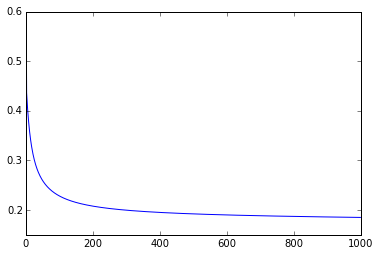

In [6]:
plt.plot(costs)
accuracy(X_val, w, y_val)

In [7]:
#STOCHASTIC TIME!
stochEpsilon = .001
w = np.array([0 for i in range(X_train.shape[1])])
def singleDIMGradient(X, w, y):
    #Pick random number
    i = random.randint(0,X.shape[0] -1)
    lambdaWeight = 2 * l * w
    return lambdaWeight - (y[i] - sigmoid(X[i].dot(w)))*X[i]
numStochIter = 1000
stochCosts = []
for iterationNum in tqdm.tqdm(range(numStochIter)):
    stochCosts.append(costF(X_train, w, y_train))
    w = w - (stochEpsilon * singleDIMGradient(X_train, w, y))

100%|██████████| 1000/1000 [00:09<00:00, 100.63it/s]


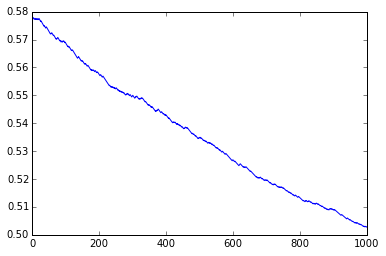

In [8]:
plt.plot(stochCosts)

In [9]:
print(accuracy(X_val, w, y_val))

0.743


In [17]:
#STOCHASTIC WITH CHANGING EPSILON!
stochChangeEpsilon = 1
w = np.array([0 for i in range(X_train.shape[1])])
def singleDIMGradient(X, w, y):
    #Pick random number
    i = random.randint(0,X.shape[0] -1)
    lambdaWeight = 2 * l * w
    return lambdaWeight - (y[i] - sigmoid(X[i].dot(w)))*X[i]
numStochIter = 1000
stochCosts = []
for iterationNum in tqdm.tqdm(range(numStochIter)):
    stochCosts.append(costF(X_train, w, y_train))
    stochChangeEpsilon = 1/float(iterationNum + 1)
    w = w - (stochEpsilon * singleDIMGradient(X_train, w, y))


100%|██████████| 1000/1000 [00:09<00:00, 102.95it/s]


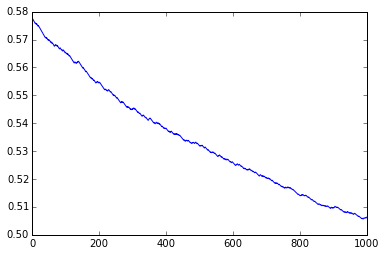

In [18]:
plt.plot(stochCosts)

In [12]:
print(accuracy(X_val, w, y_val))

0.743


In [13]:
#NEWTON'S METHOD
newtonEps = .08
newtonL = .0000000000001
def newtonWeight(w, X, y, s):
    sigmaMatrix = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        sigmaMatrix[i,i] = s[i] * (1 - s[i])
    leftSide = 2 * newtonL * X.shape[0] + X.T.dot(sigmaMatrix).dot(X)
    rightside = 2 * newtonL * w - X.T.dot(y - s)
    e = np.linalg.solve(leftSide, -rightside)
    return e
def newtonSigmoid(gamma):
    try:
        denom = 1 + math.exp(-gamma)
    except Exception as e:
        print(gamma)
    else:
        pass
    return 1/denom
def newtoncalcS(X, w):
    s = []
    for i in range(X.shape[0]):
        s.append(newtonSigmoid(X[i].dot(w)))
    return np.array(s)

def newtonaccuracy(X, w, y):
    totalA = 0
    for i in range(X.shape[0]):
        if classify(X[i].dot(w)) == y[i]:
            totalA += 1
    return float(totalA)/X.shape[0]
def getLabels(X, w):
    labels = []
    for i in range(X.shape[0]):
        labels.append(classify(X[i].dot(w)))
    return labels

In [14]:
wN = np.array([0 for i in range(X_train.shape[1])])
s = calcS(X_train, wN)
numIterations = 200
newtoncosts = []
for iterN in tqdm.tqdm(range(numIterations)):
    newtoncosts.append(costF(X_train, wN, y_train))
    wN = wN + (newtonEps * newtonWeight(wN, X_train, y_train, s))
    s = newtoncalcS(X_train,wN)

100%|██████████| 200/200 [00:32<00:00,  6.47it/s]


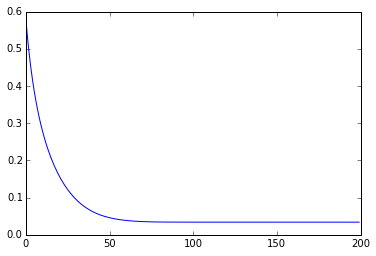

In [15]:
plt.plot(newtoncosts)

In [16]:
newtonaccuracy(X_val,wN, y_val)

0.987

In [28]:
#PRINT TO FILE
labels = getLabels(X_test, wN)
print(labels)
f = open('HW4OUT.csv', 'wt')
try:
    writer = csv.writer(f)
    writer.writerow( ('Id', 'Category') )
    for i in range(len(labels)):
        writer.writerow( (i, str(labels[i])) )
finally:
    f.close()

[0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 